# Support Vector Machines (SVM)

En este cuaderno vamos a ver, en la práctica, los conceptos más importantes de SVM
+ Vectores soporte
+ Hiperparámetro $C$
+ Diferentes *kernels* y sus hiperparámetros


---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2020, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2020, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extraer características
2. separar en TRAIN y VALID
2. seleccionar características y escalar TRAIN a [0,1]

In [1]:
#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[2]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[3]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

#-[4]. Split X_full into TRAIN and TEST in a single Stratified split

valid_size = 0.2
X_train, Y_train, X_valid, Y_valid = \
   my.single_stratified_split( X_full,Y_full, test_size=valid_size, random_state=seed)

#-[5]. Select the features and fit a scaler to [0,1]

from sklearn.preprocessing import MinMaxScaler

feat_selec= ['W_max1','H_max1']
scaler = MinMaxScaler()

X = scaler.fit_transform(X_train[feat_selec])
Y = Y_train.values.ravel()   

#---> X and Y are now numpy arrays ready to train a machine !!

## Diferencia con el clasificador NO lineal

6. En vez de realizar una transformación NO lineal al conjunto de entrenamiento se utiliza un *kernel* que devuelve productos escalares en otro espacio, posiblemente $\infty$-dimensional

Los kernels que utiliza *scikit-learn* son:<br>
\begin{array}{llll}
\text{Kernel} & \tt{sklearn} & \text{expresión}  & \text{parámetros} \\ \hline
\text{Lineal} & \tt{linear} & u^{T}v  & -- \\
\text{RBF} & \tt{rbf} & \exp(-\gamma \Vert u-v \Vert^2) & \gamma \\
\text{Sigmoide} & \tt{sigmoid} & \tanh(-\gamma \cdot u^{T}v + r) & \gamma, r \\
\text{Polinomial} & \tt{poly} & (\gamma\cdot u^{T}v + r)^d  & \gamma, r, d \\
\end{array}
donde $~ u^Tv ~$  representa el producto escalar de los vectores $u$ y $v$.

Además todos tienen el hiperparámetro $C$ para regularizar el clasificador.
+ $C$ pequeño 
$\rightarrow$ poca penalización por errores de clasificación 
$\rightarrow$ margen grande a costa de más errores de clasificación
+ $C$ grande
$\rightarrow$ mucha penalización por errores de clasificación 
$\rightarrow$ margen pequeño porque los errores de clasificación penalizan *extra*
         
$\quad$ [Leer más sobre gamma y C (6 min.)](https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167)

In [14]:
#-[6]. Learn a SVM for classification 
#      choice of kernels: linear, poly, rbf, sigmoid
#      parameters:
#      - all:     C 
#      - linear:  --
#      - rbf:     gamma
#      - sigmoid: gamma, coef0
#      - poly:    degree, gamma, coef0

from sklearn.svm import SVC

clf = SVC(kernel='rbf', C=1, gamma=0.1, random_state = seed)
clf.fit(X,Y) 

#print("Linear SVM: ",clf.__dict__)  #<- remove comment to show the attributes of CLF.
#print(clf.support_) #<- remove to show the indices of those examples in TRAIN that became support vectors

SVC(C=1, gamma=0.1, random_state=1234)

#### Predecir

+ Salvo con el kernel lineal, SVM no produce una expresión cerrada para la superficie de decisión.
+ Para poder visualizarla:
    1. Tomamos Ngrid $\times$ Ngrid puntos del intervalo $[0,1]^2$
    2. Usamos el clf. aprendido para clasificar cada punto. Para ello:
        1. calculamos un score,
        2. lo convertimos en un valor con interpretación probabilística
        3. y usamos un umbral (*threshold*) para generar la etiqueta (*tag*)
    2. Y mostramos el resultado.

In [15]:
#--parameters of this cell
Ngrid = 100
threshold = 0.5 # Set 0 < threshold < 1 to make a hard classification.

#--take Ngrid x Ngrid equally spaced points in [0,1]x[0,1]
rangeX = np.linspace(0,1,Ngrid)
rangeY = np.linspace(0,1,Ngrid)
xx,yy = np.meshgrid(rangeX,rangeY)
grid_data = np.hstack( (xx.reshape([xx.size,1]),    \
                        yy.reshape([yy.size,1]) ) )

#--predict the score according to each clf. 
y_score = clf.decision_function( grid_data )

#--predict the tag using a threshold
if threshold>0:  #  otherwise we would have the pictures above
    expit = lambda x: 1/(1+np.exp(-x)) # expit function converts score into probability
    y_prob = expit(y_score)
    y_threshold = (y_prob > threshold)
y_threshold = y_threshold.reshape([Ngrid,Ngrid])

#### Visualizar

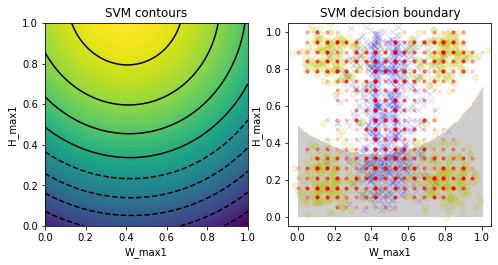

las líneas discontinuas indican 'scores' negativos o cero
1524 ejemplos del conjunto TRAIN son vectores soporte (en rojo)


In [16]:
#--parameters of this cell
unit_interv = [0,1,0,1]
origin = 'lower'
plt.rcParams['figure.figsize'] = [8,8] #<- this makes the figures larger in Jupyter

#--plot the contour
plt.subplot(121)
plt.imshow(y_score.reshape([Ngrid,Ngrid]), \
           origin=origin, extent=unit_interv)
plt.contour(xx,yy,y_score.reshape([Ngrid,Ngrid]), \
            levels=10, origin=origin, extent=unit_interv, colors='k');
plt.xlabel(feat_selec[0]);plt.ylabel(feat_selec[1]);plt.title('SVM contours')

#--plot the classifier
plt.subplot(122)
plt.rcParams['figure.figsize'] = [4,4] #<- this makes the figures larger in Jupyter

cmap = 'hot' # other choices are: 'jet' 'hot' 'cool' 'spring' 'summer' 'winter'
plt.imshow(y_threshold, origin="lower", extent=unit_interv, cmap=cmap, alpha=0.2)
plt.xlabel(feat_selec[0]);plt.ylabel(feat_selec[1]);plt.title('SVM')

#--plot the training set
sigma = 0.02

ix1 = Y>0
ix0 = ~ix1
x1_zeros = my.jitter(X[ix0,0],sigma=sigma)
x2_zeros = my.jitter(X[ix0,1],sigma=sigma)
x1_ones = my.jitter(X[ix1,0],sigma=sigma)
x2_ones = my.jitter(X[ix1,1],sigma=sigma)
plt.plot(x1_zeros, x2_zeros, 'yo', alpha=.15)
plt.plot(x1_ones, x2_ones, 'bx', alpha=.15)

strTitle = "SVM decision boundary"
plt.title(strTitle)
plt.axis([-0.05,1.05,-0.05,1.05])

#--plot the support vectors
support_ix = clf.support_
plt.plot(X[support_ix,0], X[support_ix,1], 'r.', alpha=.15)

plt.show()
print("las líneas discontinuas indican 'scores' negativos o cero")
print("%d ejemplos del conjunto TRAIN son vectores soporte (en rojo)"%clf.support_.size)

**¡¡ Varía los hiperparámetros para ver que efecto producen en la superficie de decisión !!**

## Ejercicio

+ En este cuaderno hemos aprendido a utilizar SVM para clasificación.
+ Hemos visto que según el kernel que elijamos, tendremos varios hiperparámetros.
+ La combinación de hiperparámetros con kernel modifica la expresividad del clasificador.<br>
  **¿Cómo elegir la mejor combinación??**

Diseña un código que pruebe todas las combinaciones de los siguientes hiperparámetros con kernel RBF:
+ $C$ = [1e-2, 1e-1, 1, 1e1, 1e2]
+ $\gamma$ = [1e-2, 1e-1, 1, 1e1, 1e2]

Para cada combinación debemos calcular alguna medida de rendimiento del clasificador aprendido que nos permita compararlos, y finalmente elegir el "mejor". Evidentemente para ello habrá que utilizar el conjunto VALID que hemos creado al principio. <br>
También es importante tener en cuenta el número de vectores soporte que utiliza nuestra máquina. Si utilizamos "todo" el conjunto de entrenamiento no sólo estamos memorizándolo, sino que será mucho más costoso computacionalmente hacer predicciones.

### Solucion